In [72]:
# kernel py36a2021
from LC12c import *

In [73]:
seen_classes = [0, 1, 2]
unseen_class = 3

Dist = (
    {'label': 0, 'prob': 0.1, 'mean': [0, 0], 'cov': [[9, 0], [0, 9]]},
    {'label': 1, 'prob': 0.1, 'mean': [6, 9], 'cov': [[9, 0], [0, 9]]},
    {'label': 2, 'prob': 0.1, 'mean': [12, 0], 'cov': [[9, 0], [0, 9]]},
    {'label': 3, 'prob': 0.7, 'mean': [6, 4.5], 'cov': [[9, 0], [0, 9]]})


# Analysis Module

In [74]:
gu = guruCalc(Dist, seen_classes)

C:\toolkit\Anaconda\envs\py36a2021\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


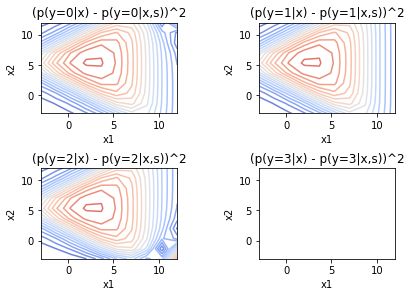

0.072441654536809
0.1652964357671098
0.06556876819529096
0.4046849665821506


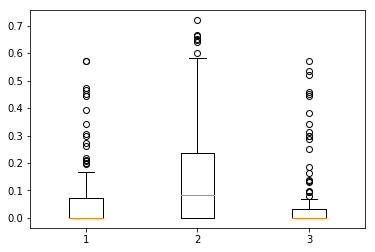

In [75]:
# Find where we can see the largest differences

diff, rel_diff = gu.posterior_diff(row_lim=(-3, 12), col_lim=(-3, 12), res=10)

# diff : list of 4 of [res x res]
for d in diff:
    print(np.average(d))

# Turn diff to 2D array of 4 x (res*res)
adiff = np.array([diff[0].ravel(), diff[1].ravel(), diff[2].ravel()])

# multiple box plots on one figure
plt.figure()
plt.boxplot(np.transpose(adiff))
plt.show()


In [10]:
import matplotlib
matplotlib.__version__

'3.0.0'

Therefore, where we get it wrong is where we will see the largest difference (where unseen locates)

Explore calculated probs

p(y)
p(y=0) = 0.1
p(y=1) = 0.1
p(y=2) = 0.1
p(y=3) = 0.7
p(x|y)


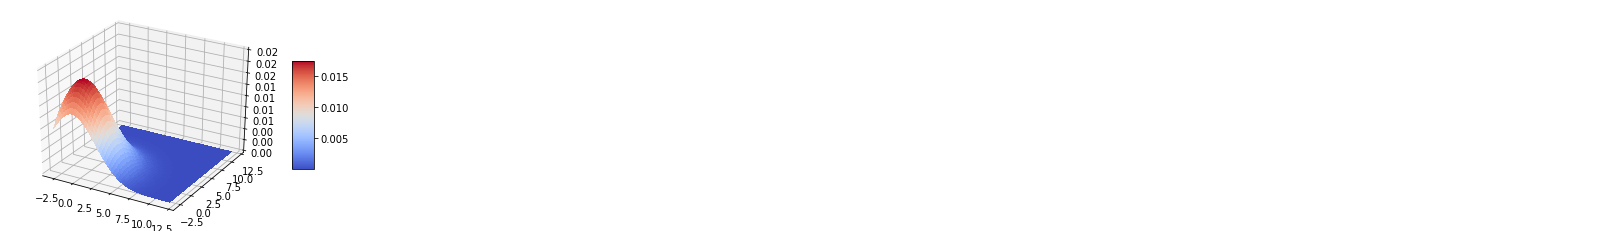

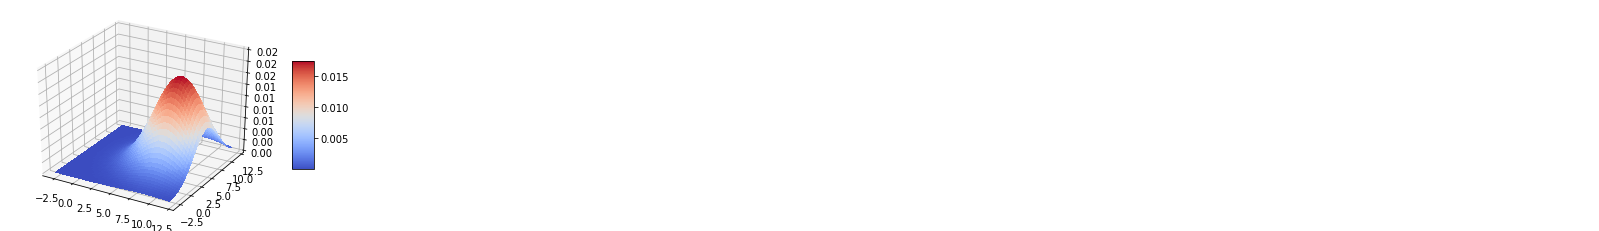

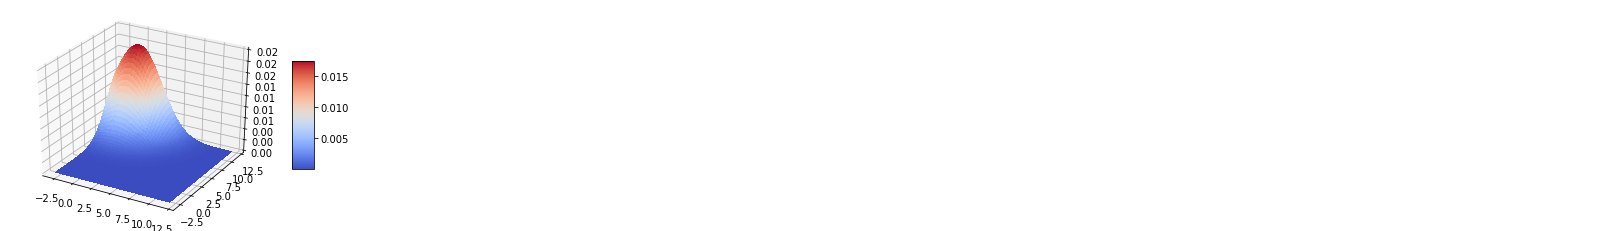

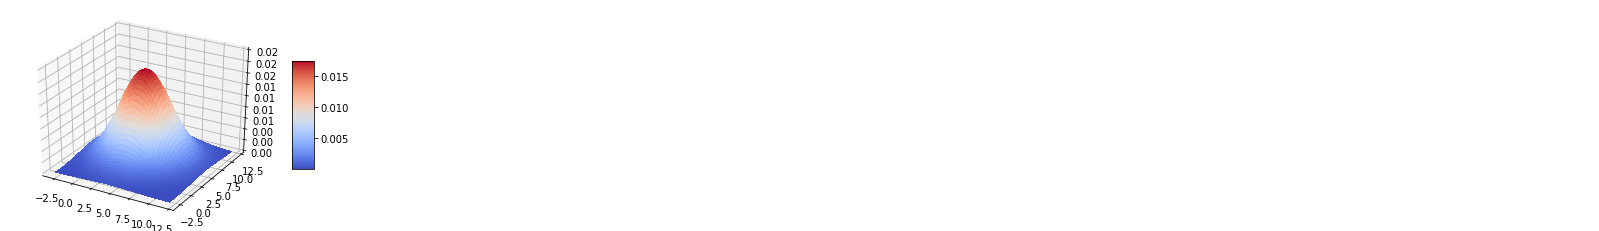

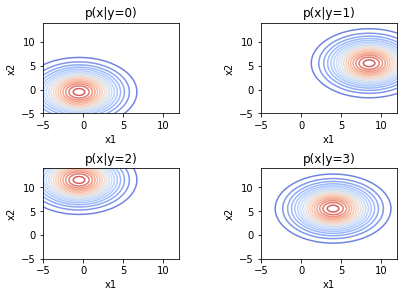

p(x)


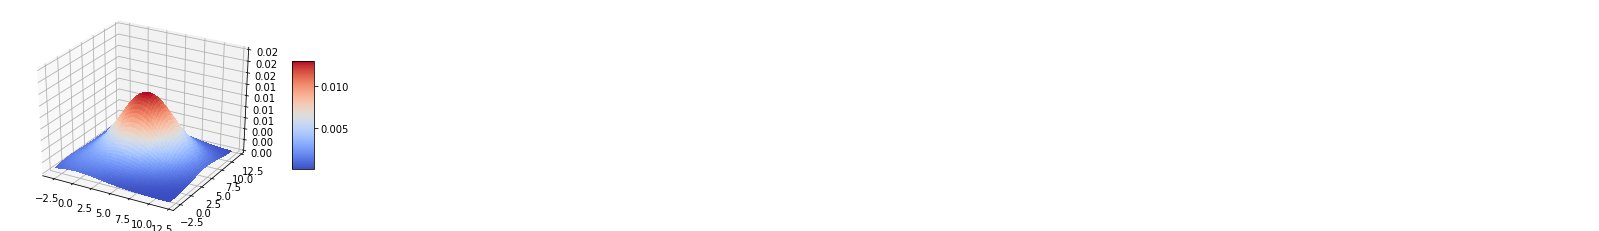

p(s)
0.30000000000000004
p(x|s)


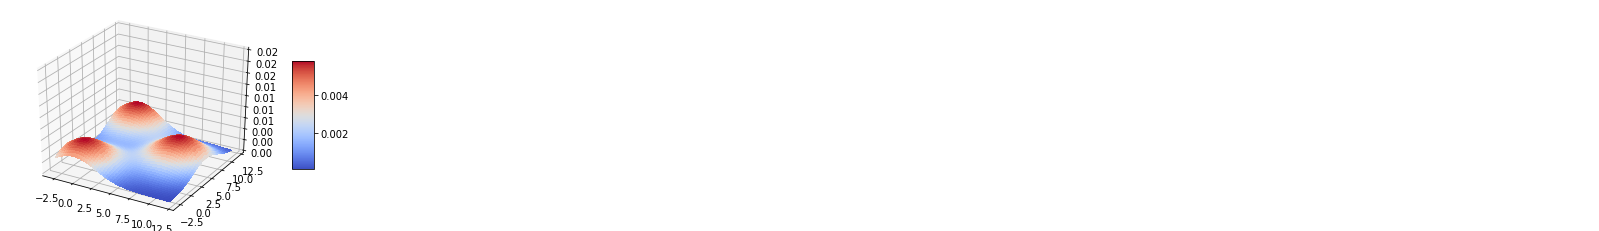

p(x,y)


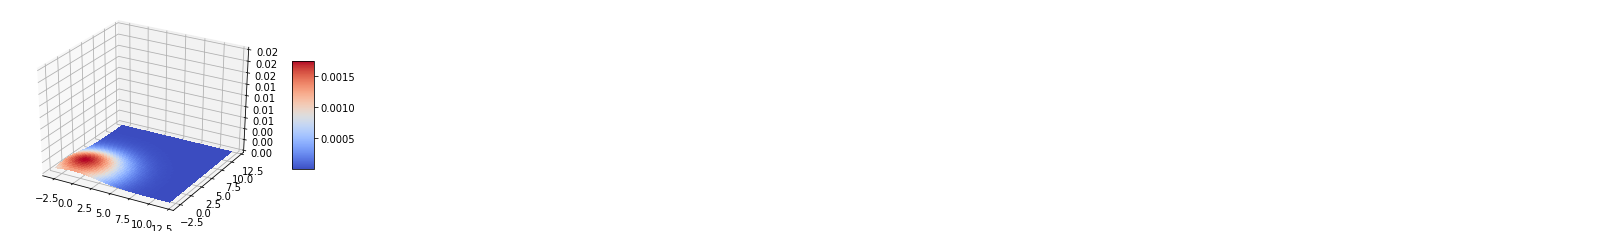

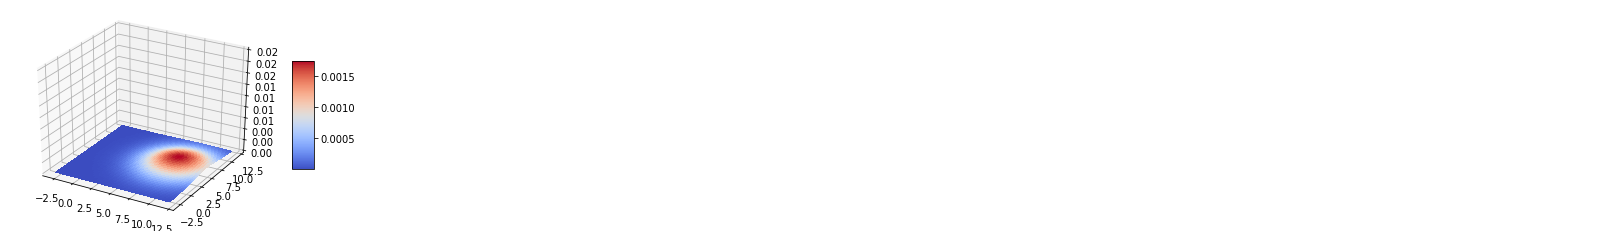

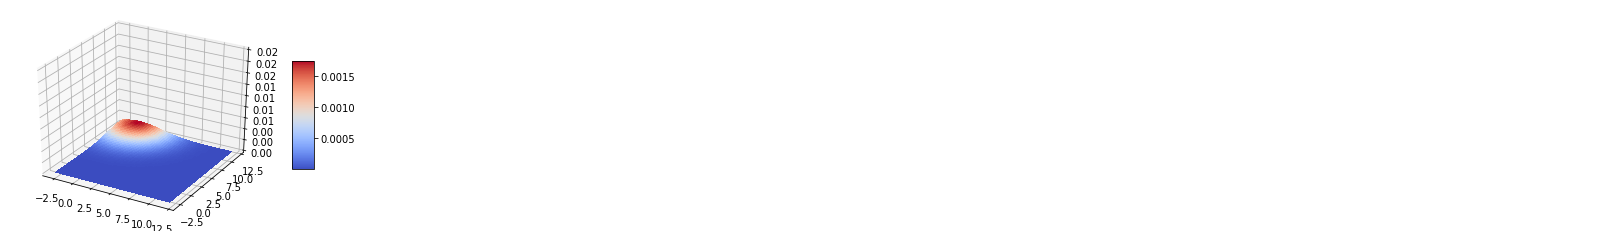

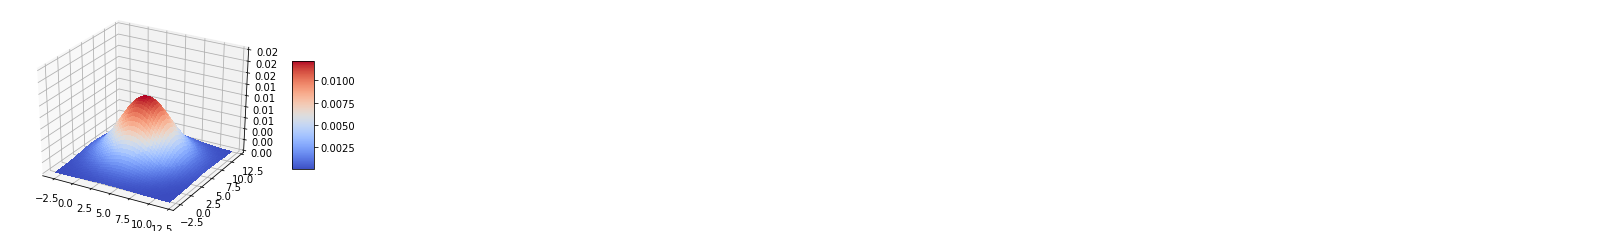

p(x,y|s)


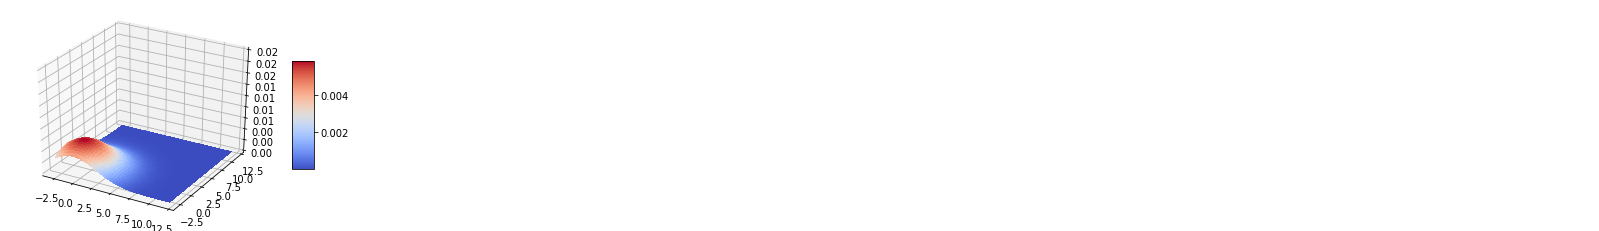

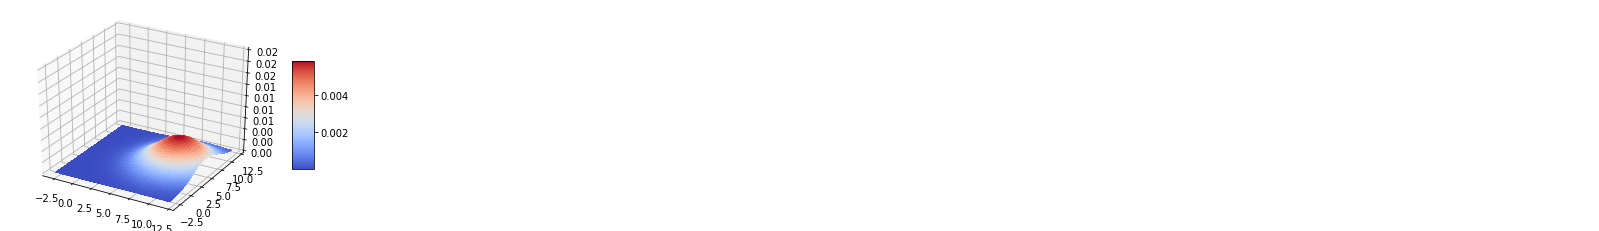

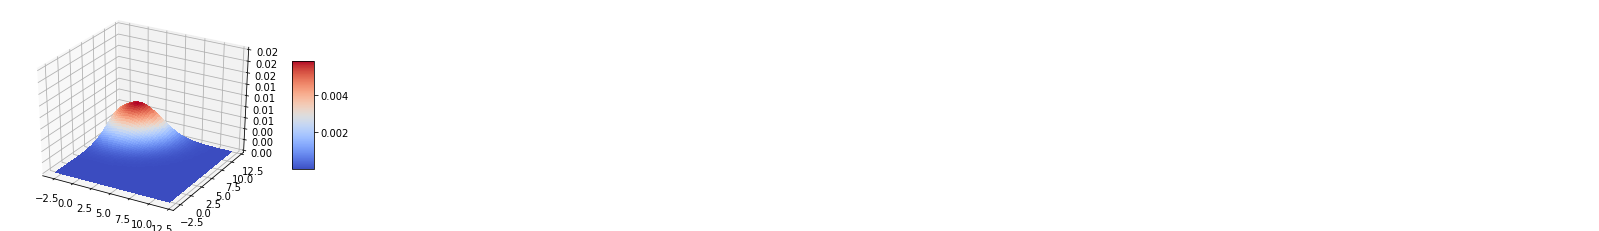

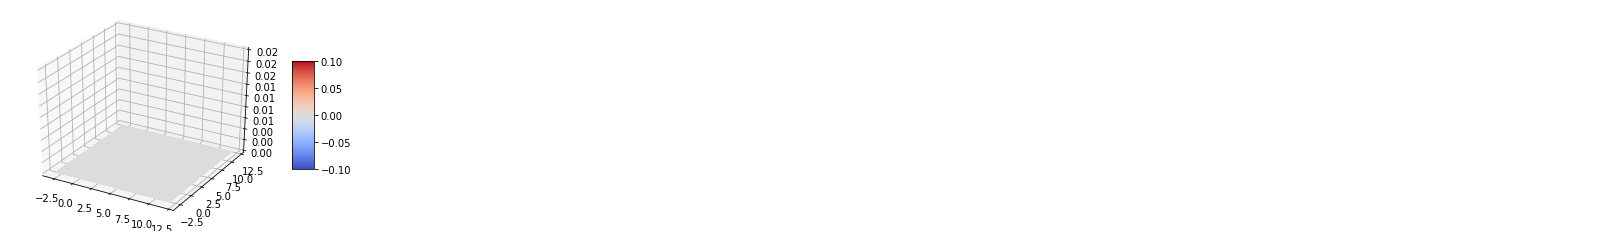

p(y|x


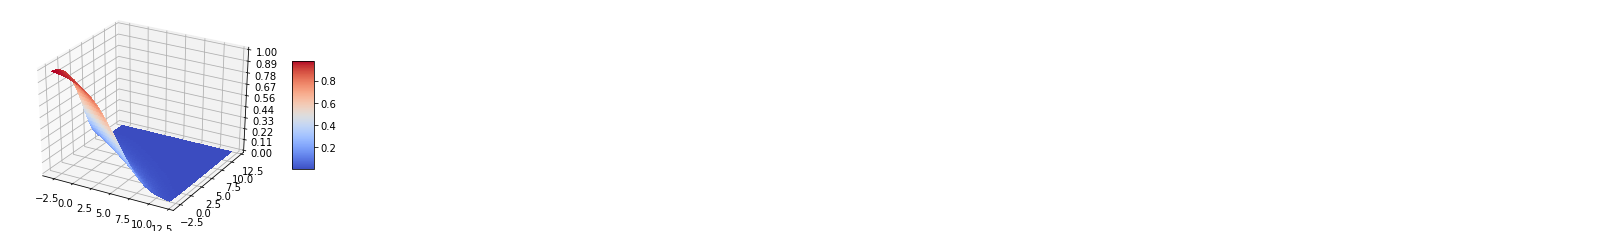

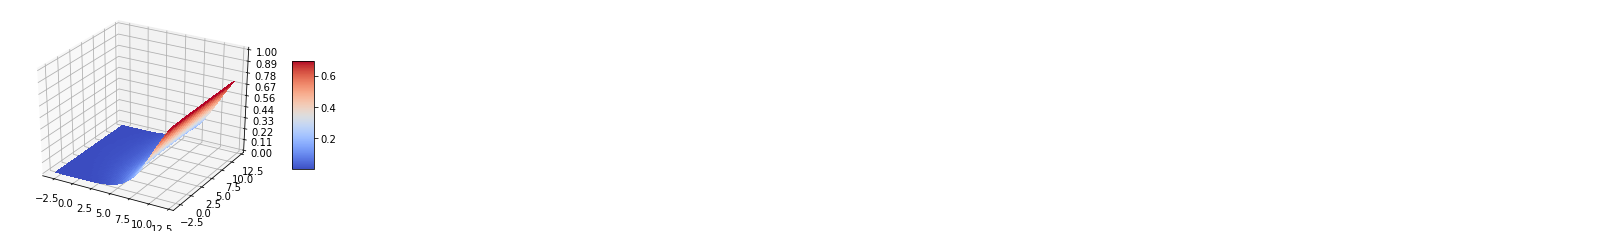

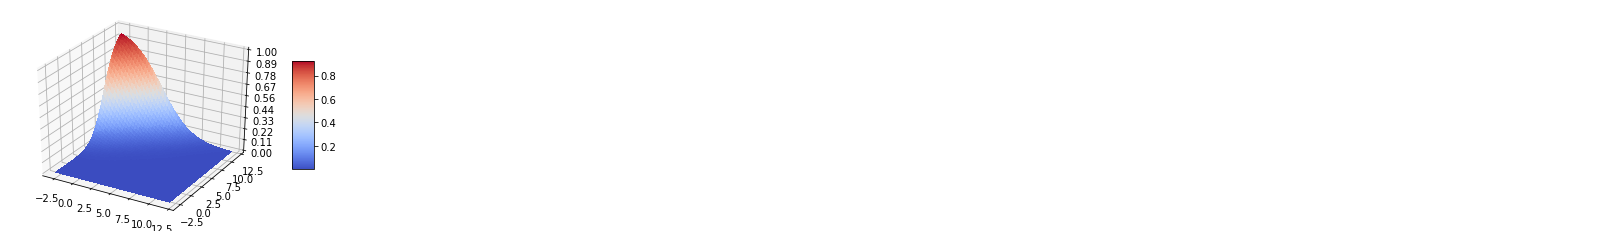

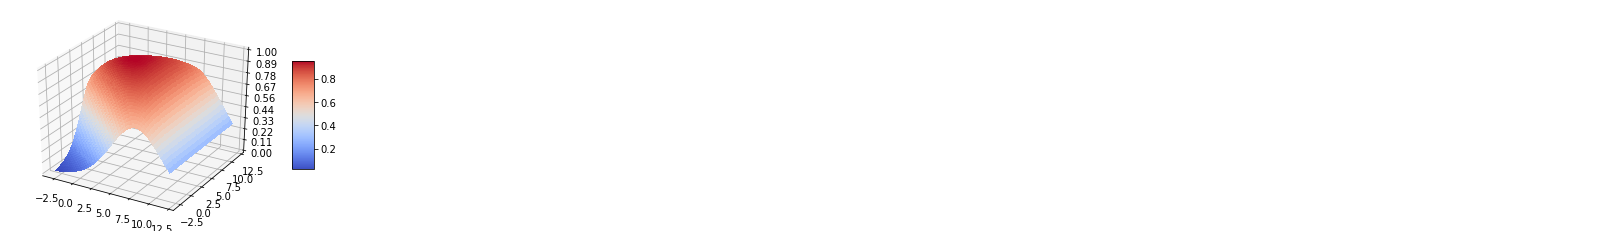

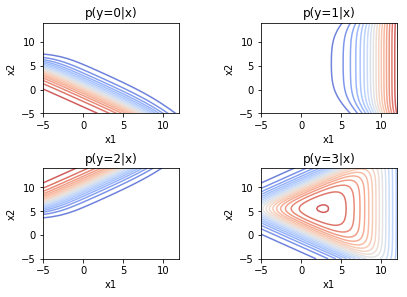

p(y|x,s


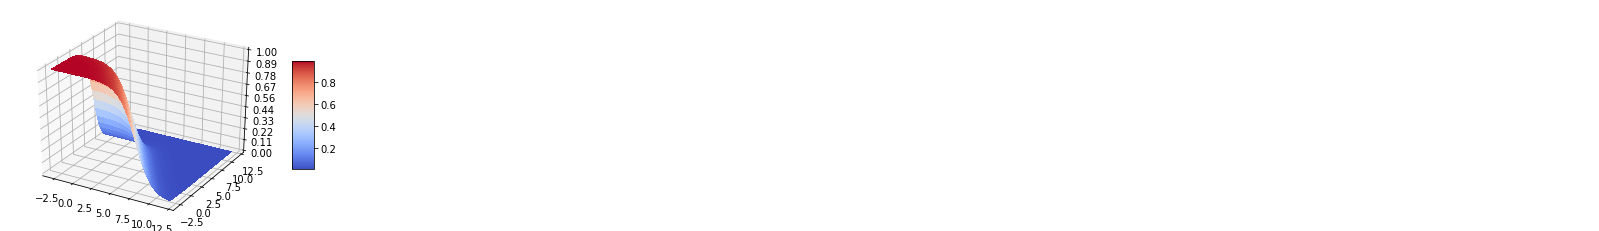

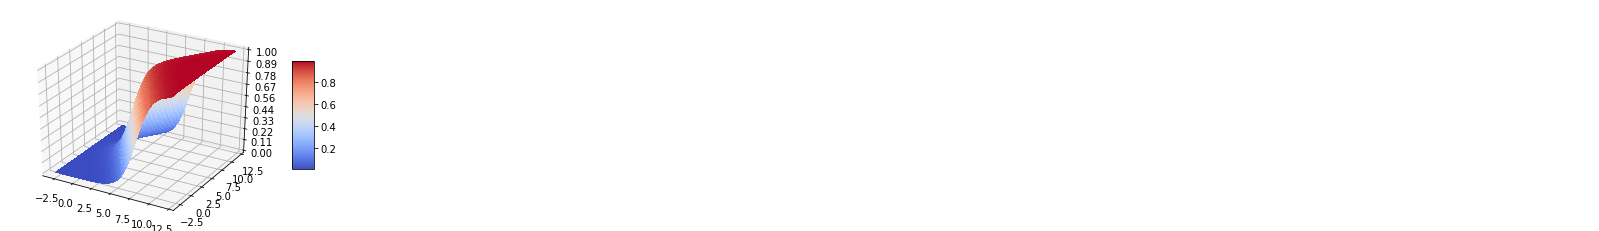

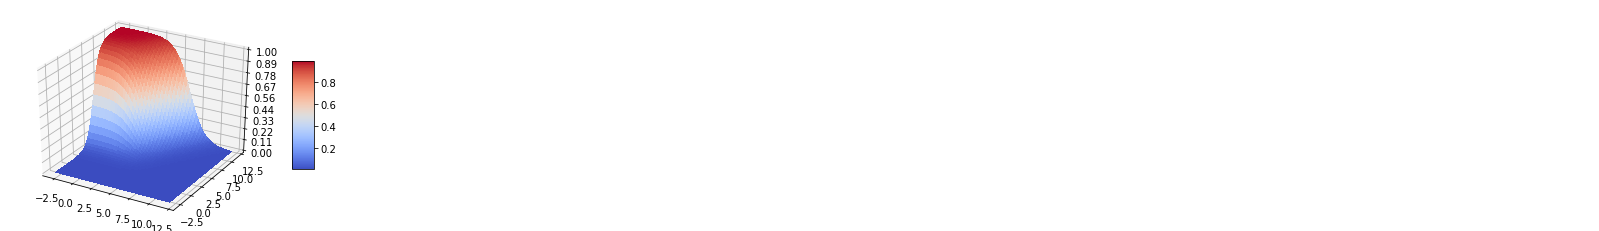

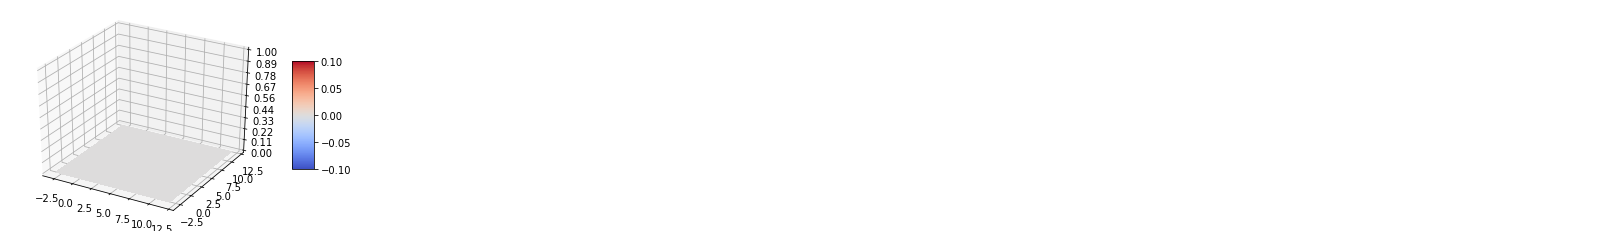

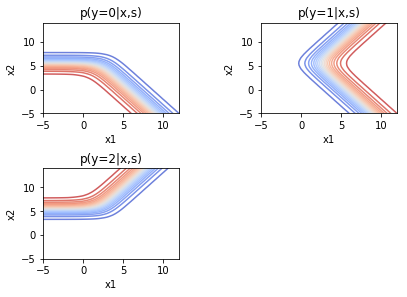

In [11]:
gu.explore_probs()

# Simulation Module

In [10]:
gs = guruSim(Dist, seen_classes)

# train (seen) =  1500
# unseen in train_y: False
# test =  501
# unseen in test_y: False


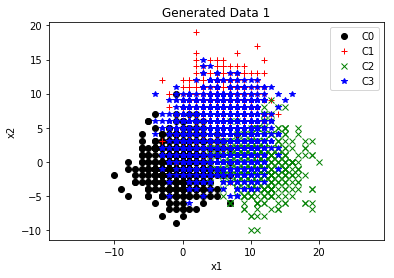

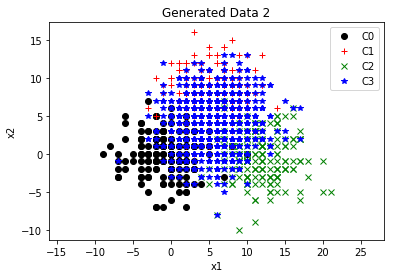

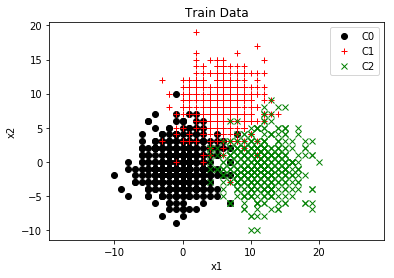

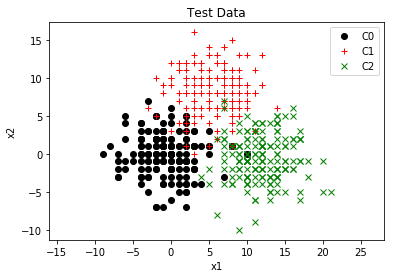

In [11]:
gs.prepare_data(1500, 500)
gs.plot_data2D(gs.All_Data[0], title='Generated Data 1')
gs.plot_data2D(gs.All_Data[1], title='Generated Data 2')
gs.plot_Data(gs.Train_Data, title='Train Data')
gs.plot_Data(gs.Test_Data, title='Test Data')


In [12]:
print(gs.Train_Data['x'].shape)
print(gs.Train_Data['y'].shape)

(1500, 2)
(1500,)


In [51]:
print(gs.Test_Data['x'].shape)
print(gs.Test_Data['y'].shape)

(501, 2)
(501,)


In [25]:
ttrainx = torch.from_numpy(gs.Train_Data['x']).float().to(device)
ttrainy = torch.from_numpy(gs.Train_Data['y']).float().to(device).long()

In [46]:
ttestx = torch.from_numpy(gs.Test_Data['x']).float().to(device)
ttesty = torch.from_numpy(gs.Test_Data['y']).float().to(device).long()

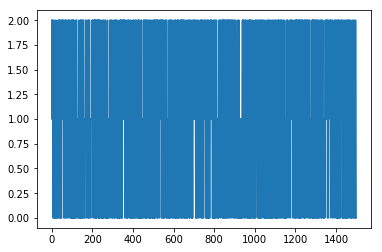

In [59]:
plt.plot(ttrainy.to('cpu').numpy())

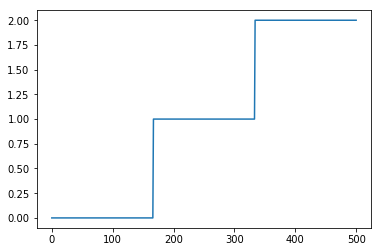

In [60]:
plt.plot(ttesty.to('cpu').numpy())

# Build and train a model

In [13]:
# cuda 9.1.84 (NVDia Control Panel > System Information > Components > NVCuda.dll)
# pytorch version 1.0.0

# https://pytorch.org/get-started/previous-versions/
# conda install pytorch==1.0.0 torchvision==0.2.1 cuda90 -c pytorch

In [14]:
import torch
torch.__version__

'1.0.0'

In [41]:
# Define model
device = torch.device('cuda')
model = torch.nn.Sequential(
    torch.nn.Linear(2, 16), torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
).to(device)

In [16]:
# Define model
#model = keras.Sequential([
#    keras.layers.Dense(input_shape=16, activation='relu'),
#    keras.layers.Dense(3, activation='softmax')
#])

#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

In [42]:
# Prepare the training
import time

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [43]:
print(optimizer.state_dict)

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)>


In [44]:
# Train the model

nepochs = 2000;

start = time.time()

train_losses = []
for t in range(nepochs):
    model.zero_grad()
    # Forward pass
    yhat = model(ttrainx)
    loss = loss_fn(yhat, ttrainy)

    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    train_losses.append(loss.item())
# end for t    
    
end = time.time()
print('Elapse time:{}'.format(end - start))

torch.save(model.state_dict(), './sav/net1.pth')


Elapse time:71.44666481018066


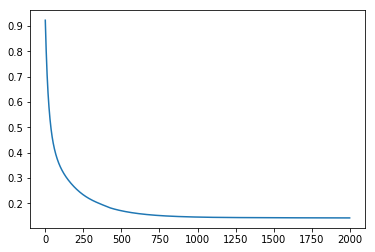

In [45]:
plt.plot(range(len(train_losses)), train_losses)

In [50]:
ttesty.shape[0]

501

In [64]:
# Test the model
model.eval()
yhat = model(ttestx)

In [66]:
# Assess the accuracy
yhatc = torch.argmax(yhat, 1)
N = ttesty.shape[0]
correct = torch.sum(yhatc == ttesty).to('cpu').numpy()
acc = correct / N
print('# correct prediction:', correct)
print('Accuracy:', acc)

# correct prediction: 472
Accuracy: 0.9421157684630739


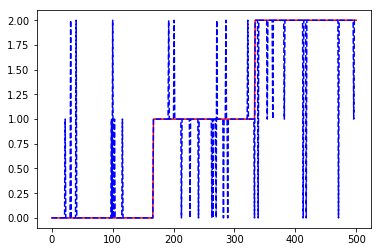

In [67]:
plt.plot(ttesty.to('cpu').numpy(), 'r-')
plt.plot(yhatc.to('cpu').numpy(), 'b--')

# Examine softmax output

In [76]:
results = []
for x in gs.Test_Data['x']:
    _softmax  = model(torch.from_numpy(np.array([x])).float().to(device))
    _conv     = [gu.pyCx(0, x), gu.pyCx(1, x), gu.pyCx(2, x)]
    _lacz     = [gu.pyCxs(0, x), gu.pyCxs(1, x), gu.pyCxs(2, x)]
    results.append({'softmax': _softmax[0], 'conv': _conv, 'lacz': _lacz})

#np.save('Front_LC12a_190210a.npy', results)

See difference

In [77]:
N = len(results)
diff_conv = np.zeros((N, 3))
diff_lacz = np.zeros((N, 3))
d_conv_lacz =np.zeros((N, 3))

for i, r in enumerate(results):
    for j in range(3):
        diff_conv[i,j] = (r['softmax'][j] - r['conv'][j])**2
        diff_lacz[i,j] = (r['softmax'][j] - r['lacz'][j])**2
        d_conv_lacz[i,j] = (r['conv'][j] - r['lacz'][j])**2

In [79]:
print(['softmax - convention', 'softmax - LC', 'convention - LC'])
print(np.mean(diff_conv, axis=0))
print(np.mean(diff_lacz, axis=0))
#print(np.mean(d_conv_lacz, axis=0))


['softmax - convention', 'softmax - LC', 'convention - LC']
[22.70641385 14.19658328 10.28275726]
[22.14623429 12.77419384  9.89812075]


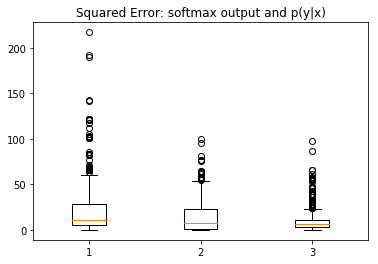

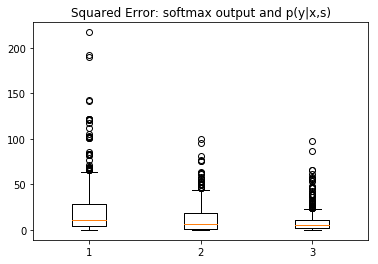

In [80]:
# # multiple box plots on one figure
plt.figure()
plt.boxplot(diff_conv)
plt.title('Squared Error: softmax output and p(y|x)')
plt.show()

plt.figure()
plt.boxplot(diff_lacz)
plt.title('Squared Error: softmax output and p(y|x,s)')
plt.show()

To Do:
    1. Experiment with different proporation of unseen: 0.1, 0.4, 0.7, 0.91, 0.94, 0.97
    2. Experiment with different variances: var = 7, 9, 11, 13, 15, 17, 19

In [14]:
gu.pyCx.__doc__

'\n        Posterior p(y|x)\n        '

In [15]:
gu.pyCx(0, gs.Test_Data['x'][0,:])

0.77309305340255208

In [16]:
gs.Test_Data['x'][0,:]

array([-1.,  0.])

In [17]:
conv = gu.pyCx(0, np.array([4,5])); conv

0.0097353111991354616

In [18]:
lc = gu.pyCxs(0, np.array([4,5])); lc

0.11915747848386597

In [19]:
_yk = model.predict(np.array([[4,5]]))
_yk

array([[ 0.21915616,  0.77340001,  0.00744388]], dtype=float32)

In [20]:
print(_yk[0,0] - conv, _yk[0,0] - lc)

0.209420849752 0.0999986824668
